In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-10-05 15:57:10.007134: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
ind_pick_from_batch = [0, 3, 4, 8, 9, 10, 13, 14, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)

In [6]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead4.npy"))

filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead4.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [90]:
glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_*_indx29_indy34_lead2.npy")

['/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy34_lead2.npy']

In [91]:
name1 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy'

name2 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy34_lead2.npy'
name3 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy35_lead2.npy'
name4 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy36_lead2.npy'

name5 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy34_lead2.npy'
name6 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy'
name7 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy36_lead2.npy'

name8 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy34_lead2.npy'
name9 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy35_lead2.npy'
name10 = '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy36_lead2.npy'

In [92]:
filename_valid = [name1, name2, name3, name4, name5, name6, name7, name8, name9, name10]

In [93]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

In [94]:
L_valid = len(filename_valid)
L_var = L_vars

TEST_input = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

**ConvNext**

In [95]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [96]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(64, 64, 12)
classes=1

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT)

OUT = layers.Dense(128, name="{}_dense1".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

In [97]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [98]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [99]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'FC_12_Lead2'

model_name = '{}_pp23_tune'.format(key)
model_path = temp_dir+model_name

W_old = k_utils.dummy_loader(temp_dir+'FC_12_Lead2_pp23')
model.set_weights(W_old)


In [100]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-5))
#keras.losses.BinaryCrossentropy(from_logits=True)

In [101]:
X_batch = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [102]:
Y_pred = model.predict([TEST_input,])

In [103]:
# save_dict = {}
# save_dict['y_true'] = TEST_target
# save_dict['y_pred'] = Y_pred

# np.save("ALL_pred_lead2.npy", save_dict)

In [104]:
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

1.161344792512048
Initial record: 1.161344792512048


In [105]:
# 0.034775568168985756
# Initial record: 0.034775568168985756

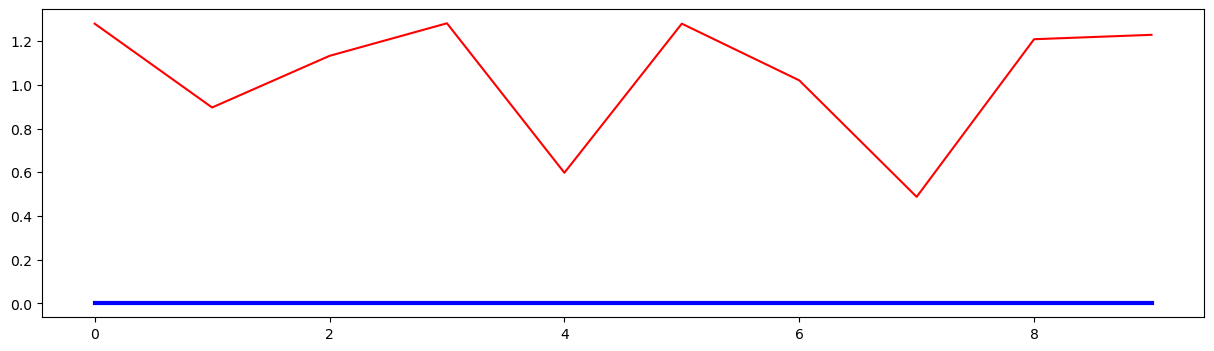

In [106]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target, 'b-', lw=3.0)
plt.plot(Y_pred, 'r-')
#plt.plot(Y_pred>0.5)

In [107]:
names = [
    'Max/Comp Radar',
    'MSLP',
    'AGL',
    'UH 2-5 km',
    'UH 0-2 km',
    'UH 0-3 km',
    'Vorticity 0-2 km',
    'Vorticity 0-1 km',
    'Graupel mass',
    'T 2m',
    'Dewpoint 2m',
    'U 10m',
    'V 10m',
    'SPD 10m',
    'APCP',
    'CAPE',
    'CIN',
    'SRH 0-3 km',
    'SRH 0-1 km',
    'U shear 0-1 km',
    'V shear 0-1 km',
    'U shear 0-6 km',
    'V shear 0-6 km']

name_pick = []
ind_pick_from_batch = [0, 3, 4, 8, 9, 10, 13, 14, 17, 18, 21, 22]

for i in ind_pick_from_batch:
    #print(names[i])
    name_pick.append(names[i])

In [108]:
filename_valid

['/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy34_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy35_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy36_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy34_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy36_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy34_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy35_lead2.npy',
 '/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy36_lead2.npy']

/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy34_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy35_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx27_indy36_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy34_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy35_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx28_indy36_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy34_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy35_lead2.npy
/glade/scratch/ksha/DATA/NCAR_batch/VALID_day757_neg_neg_neg_indx29_indy36_lead2.npy


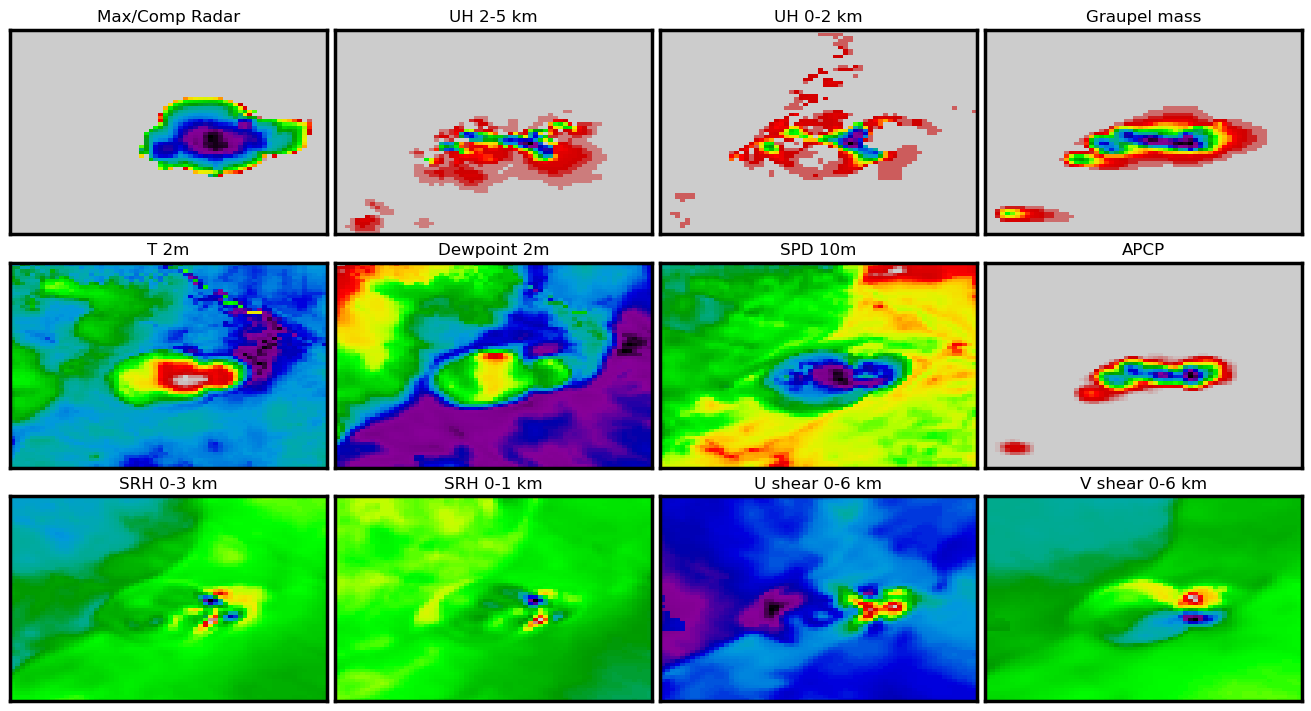

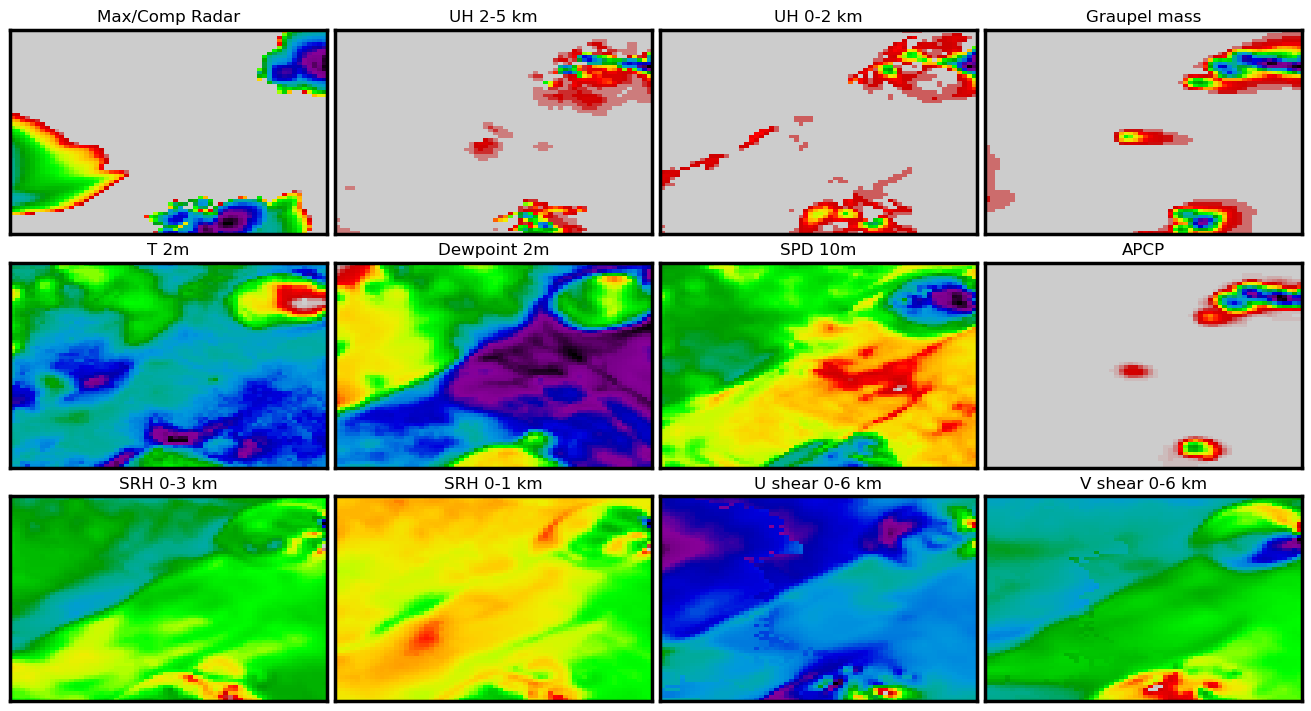

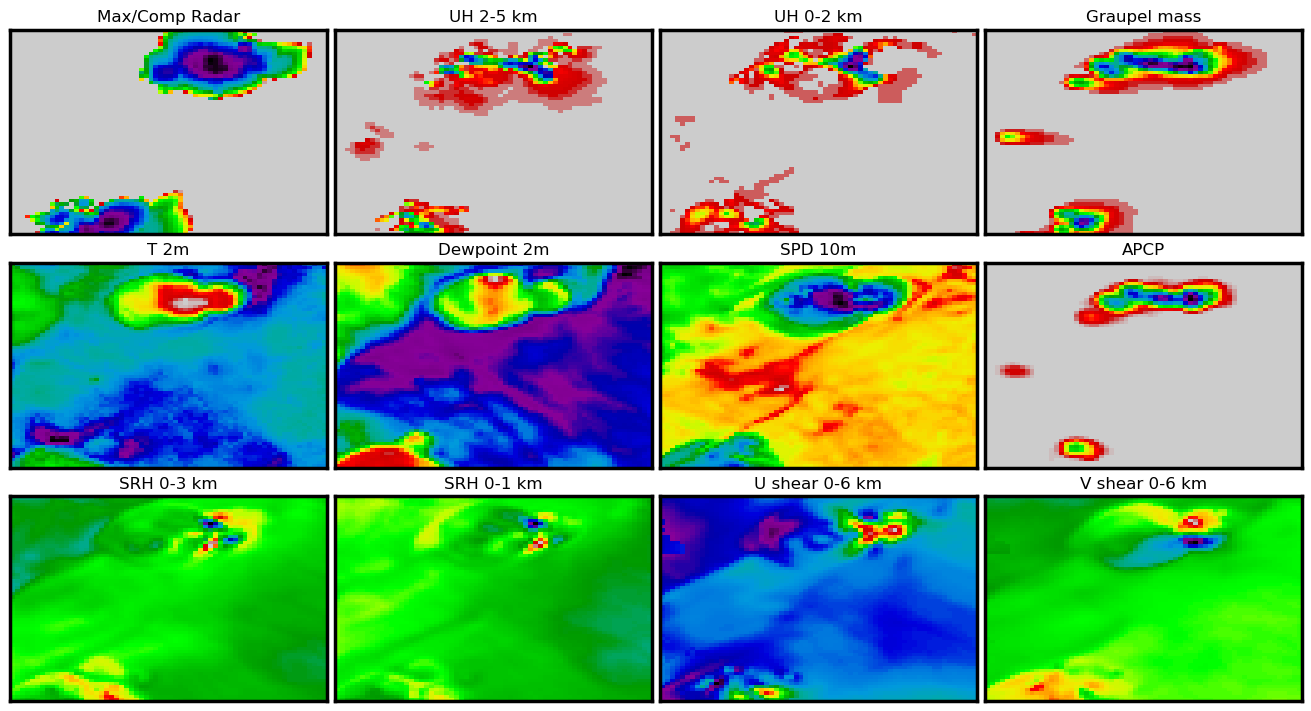

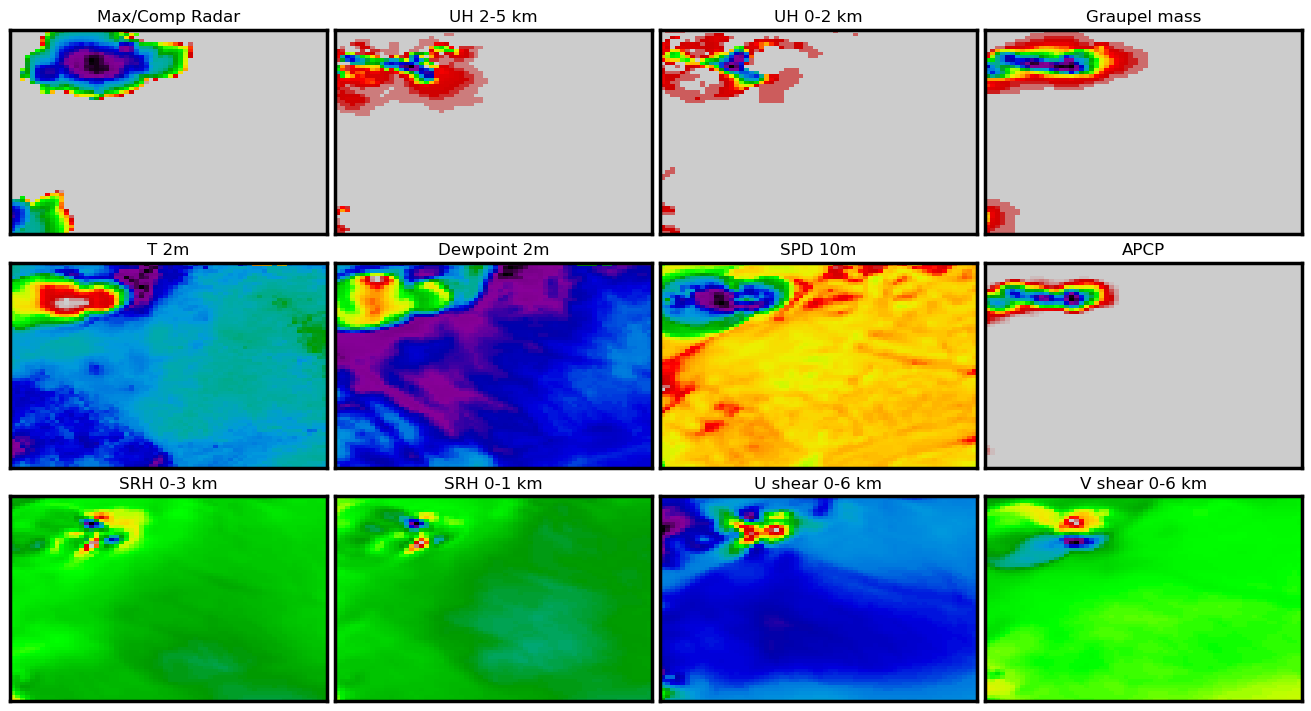

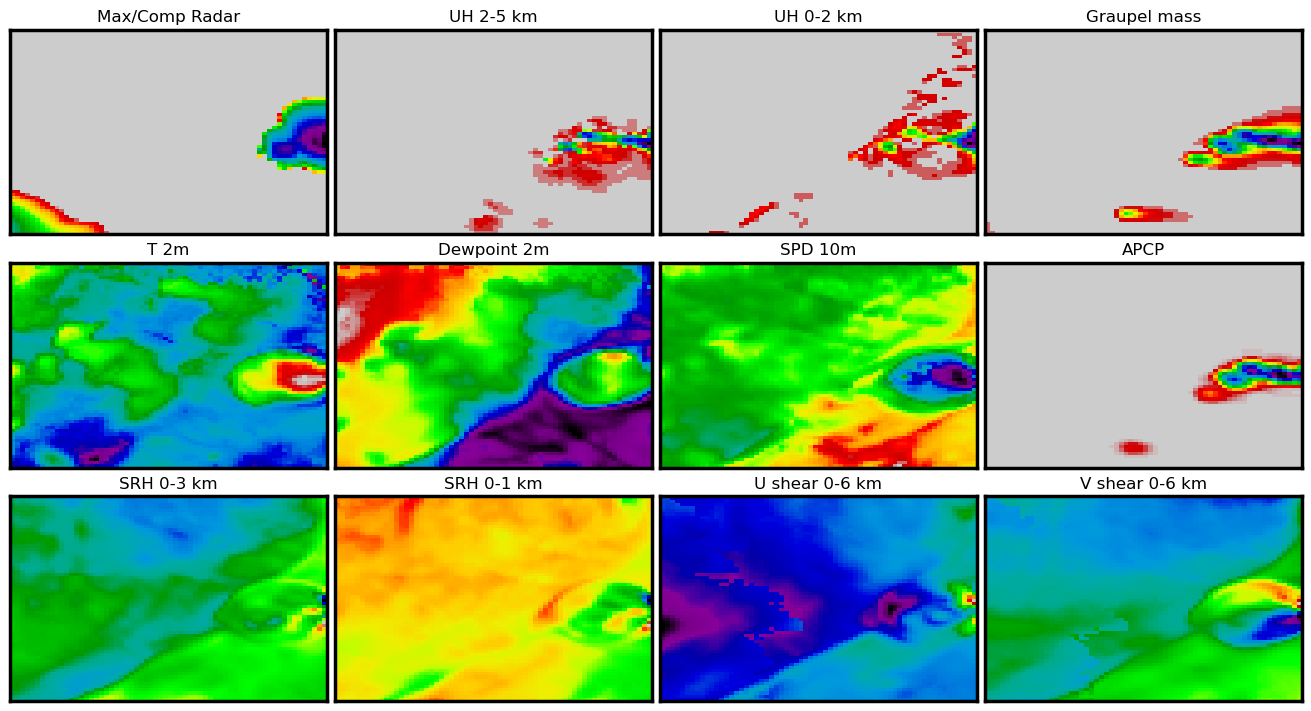

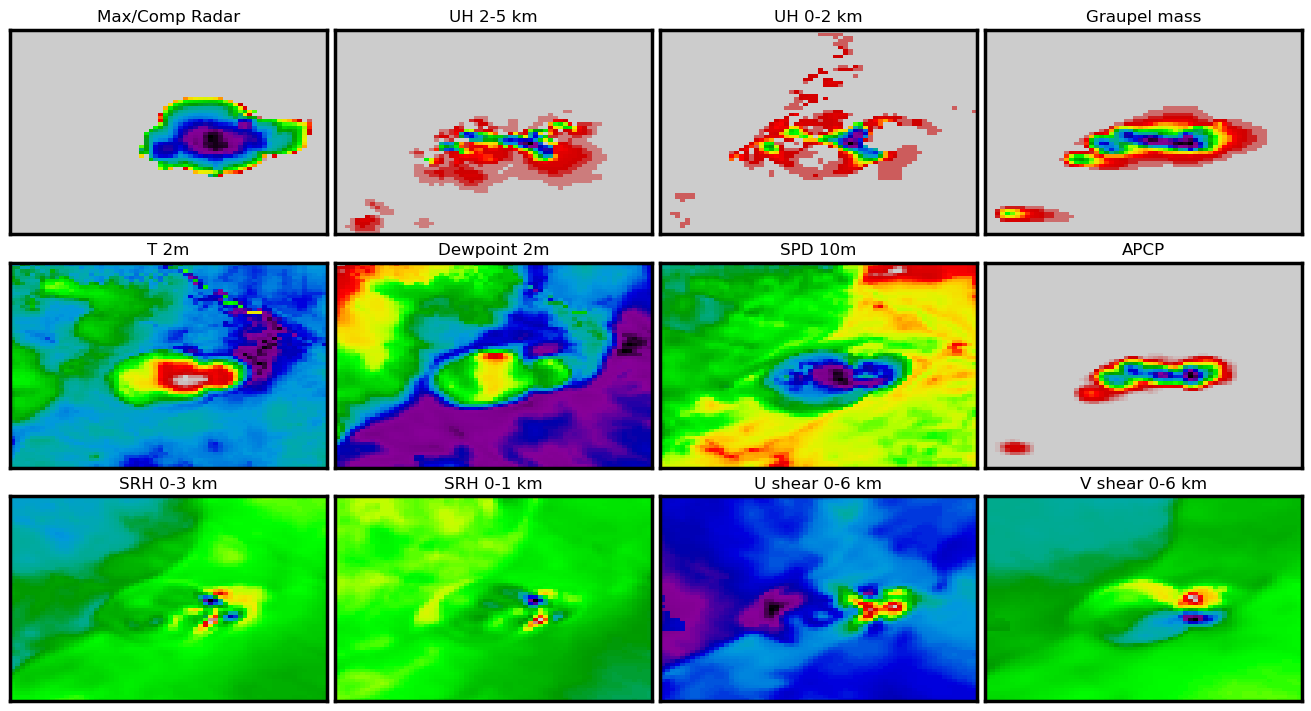

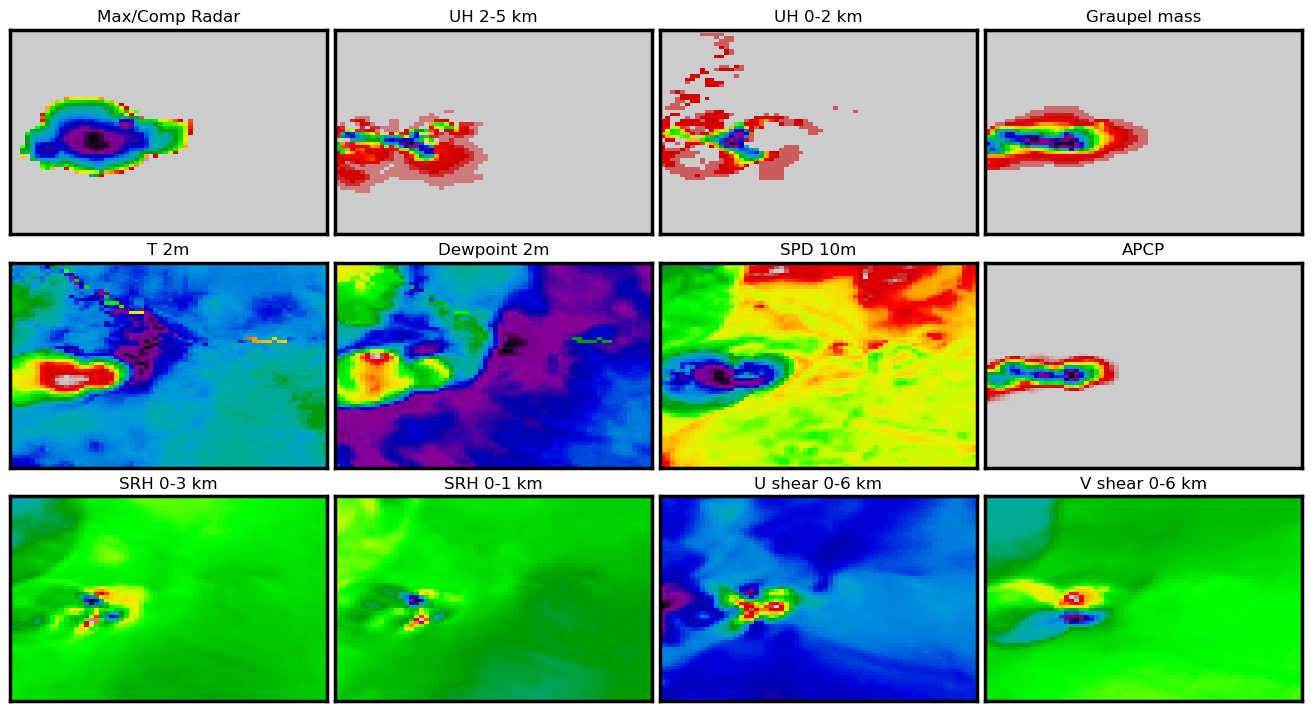

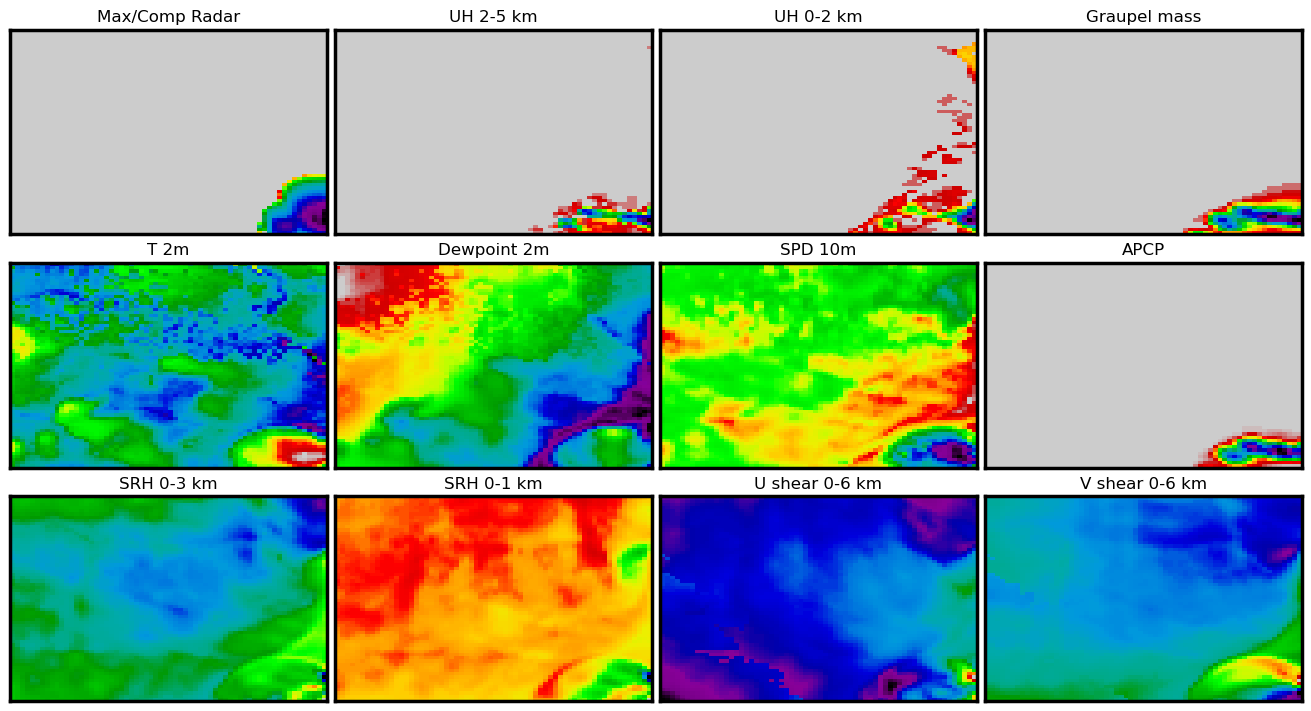

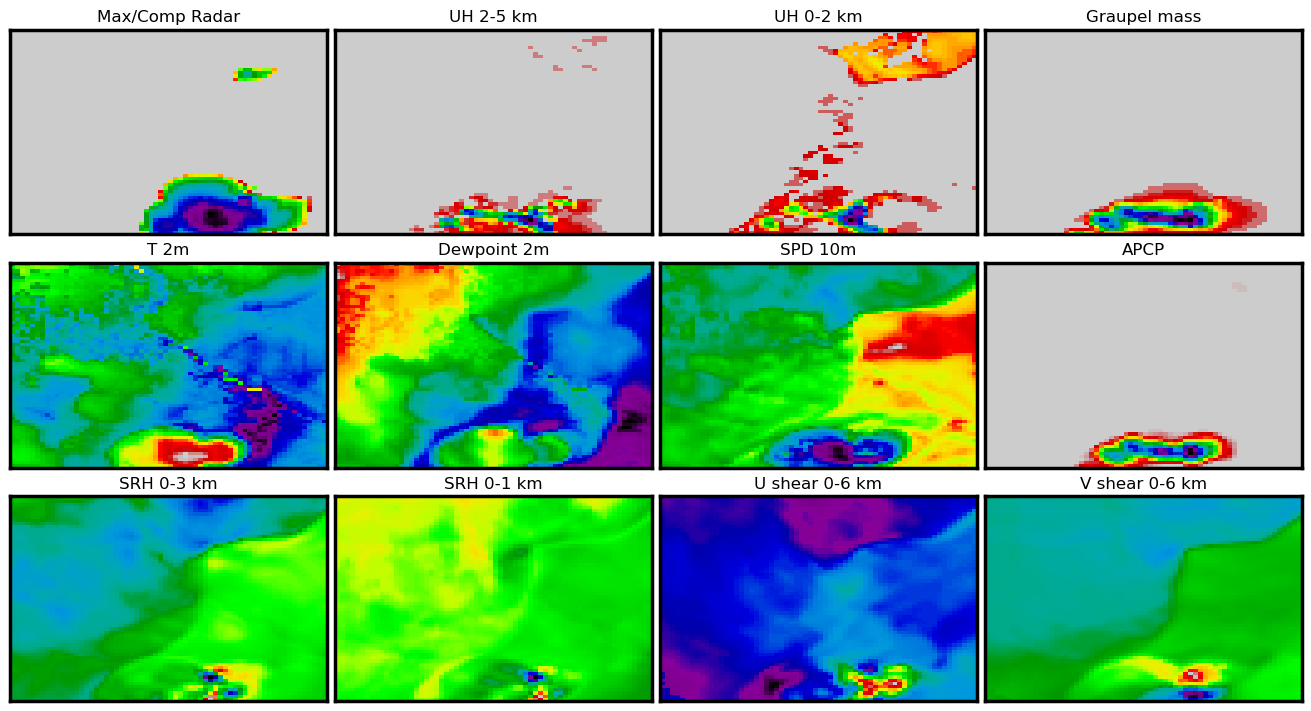

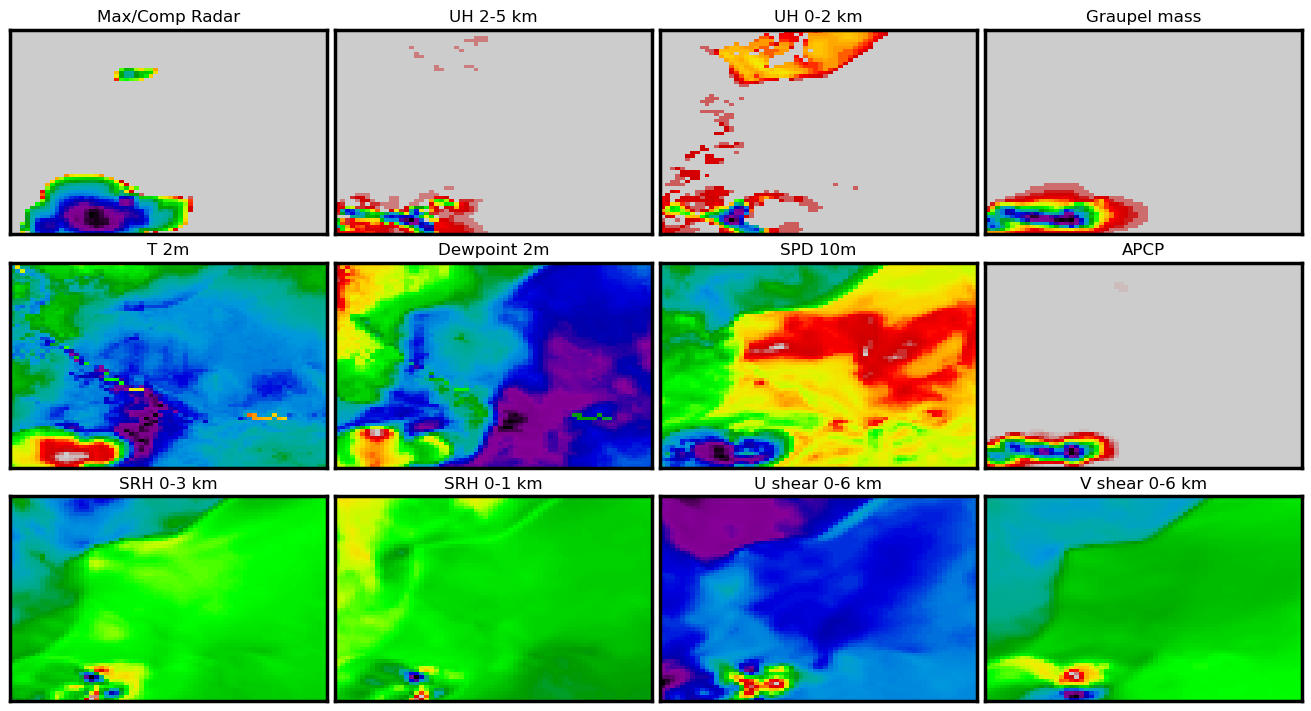

In [109]:
for i, filename in enumerate(filename_valid):

    data = np.load(filename)
    
    print(filename)
    
    fig, AX = plt.subplots(3, 4, figsize=(13, 7), constrained_layout=True)
    AX = AX.ravel()
    for i, ax in enumerate(AX):
        ax = gu.ax_decorate_box(ax)
        try:
            ax.pcolormesh(data[0, ..., ind_pick_from_batch[i]], cmap=plt.cm.nipy_spectral_r)
            ax.set_title(name_pick[i])
        except:
            continue

In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1